In [14]:
# here are the modules we'll be using throughout this notebook
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
from scipy import stats
import numpy as np
import pandas as pd

In [6]:
df = pd.read_csv('data/cleaned_data.csv', parse_dates=['date'])

df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
2,2014-05-02,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
3,2014-05-02,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA
4,2014-05-02,490000.0,2.0,1.00,880,6380,1.0,0,0,3,880,0,1938,1994,522 NE 88th St,Seattle,WA 98115,USA


We have 3 problems :

1. Houses with 0 bedroom
2. Giant outlier at almost $27M - 50 times the price of a normal house
3. 49 houses without a price

We'll take the easy way out - remove them from our analysis.

In [7]:
# new dataframe without problem #1 #2 #3
df_new = df[(df.price<2.5*10**7) & (df.bedrooms>0) & (df.price>0)].copy()

df_new.shape

(4515, 18)

Now, there is one other potential problem with our data. There are too few houses with more than 6 bedrooms. This is a problem if we want to use the number of bedrooms as a predictor of house price.

To fix this, we can simply group the houses with 7, 8 and 9 bedrooms with the houses featuring 6 bedrooms.

In [8]:
#recode houses with more than 6 bedrooms as 6 bedrooms
df_new['bedrooms_recoded'] = df_new['bedrooms'].replace([7,8,9],6)

In [11]:
df_new['renovated_0_1'] = df_new['yr_renovated']/df_new['yr_renovated']
df_new['renovated_0_1'] = df_new['renovated_0_1'].fillna(0)

**Correlation chart**

In [12]:
df_new.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country', 'renovated_0_1'],
      dtype='object')

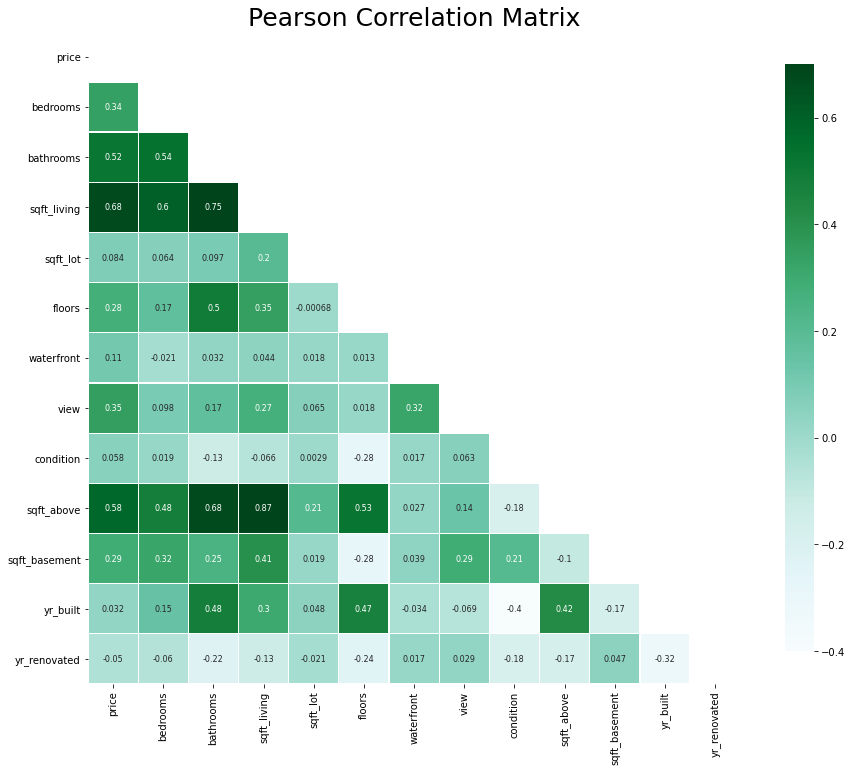

In [15]:
features = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated']
mask = np.zeros_like(df_new[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df_new[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

From the corr chart above, we could identify 6 features that have strong correlation with the target `price`

1. sqft_above
2. view
3. sqft_living
4. bathrooms
5. bedrooms
6. floors

In [16]:
# Move our features into the X DataFrame
X = df_new.loc[:,['bedrooms', 'floors','view','bathrooms','sqft_above', 'sqft_living']]

# Move our labels into the y DataFrame
y = df_new.loc[:,['price']] 

In [17]:
# separate y and X into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3612, 6) (903, 6) (3612, 1) (903, 1)


In [18]:
#train a basic multiple regression model and print out the coefficients
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.875
Model:                            OLS   Adj. R-squared (uncentered):              0.875
Method:                 Least Squares   F-statistic:                              4220.
Date:                Wed, 04 Nov 2020   Prob (F-statistic):                        0.00
Time:                        21:55:33   Log-Likelihood:                         -49495.
No. Observations:                3612   AIC:                                  9.900e+04
Df Residuals:                    3606   BIC:                                  9.904e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

We can see for each of our predictor variables, (bedrooms, floors, view, sqft_living, sqft_above, bathrooms) there are several columns - coef, std err, t, P>|t|, [0.025 and 0.975]. The column we need to check first is P>|t|. It tells us what is the probability that our coefficients are equal to zero, meaning our predictor variables do not have an impact on price.

Here we're lucky - most of these probabilities are zero, except for the sqft_above of the house 

The probability that sqft_above is zero is 25.9%.

The next thing we can check is the coefficients themselves - what is the most important predictor variable? Here it seems that it's view, followed closely by floors. According to the model, if the house has a view, it will gain about $ 75k in value (7.567+04 = 7,567*(10^4))

So this is obviously not a great model, but let's see what it does right and what it does wrong.

In [19]:
# Ask the model to predict prices in the train and test set based just on our predictor variables
lr = LinearRegression()
lr.fit(X_train,y_train)
test_pre = lr.predict(X_test)
train_pre = lr.predict(X_train)

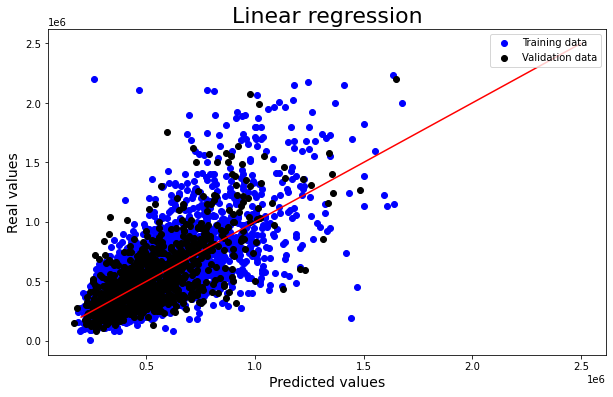

In [20]:
# Now let's plot our predicted values on one axis and the real values on the other axis
plt.figure(figsize=(10,6))
plt.scatter(train_pre, y_train, c = "blue",  label = "Training data")
plt.scatter(test_pre, y_test, c = "black",  label = "Validation data")
plt.title("Linear regression", size=22)
plt.xlabel("Predicted values", fontsize=14)
plt.ylabel("Real values", fontsize=14)
plt.legend(loc = "upper right")
plt.plot([0.2*10**6, 0.25*10**7], [0.2*10**6, 0.25*10**7], c = "red")
plt.show()

It seems our model has trouble with high-value houses though. It accurately forecasts the price of cheap and moderately priced properties, but when prices rise on the y axis, this is where we start to deviate from the ideal red line. The poster child for this prediction error is the obvious outlier sitting at 1.2x10^7 = a 12 million dollar house, where our model predicted less than $ 500 000!

Now let's compute the mean error.

In [21]:
#get the results from the regression in dataframe format
res = pd.DataFrame(data=train_pre, columns=['predicted values'])
#join with the actual prices
res = y_train.reset_index().join(res)
#join with the training dataset
resfin = res.join(X_train, on='index',lsuffix='_y')
# compute the actual prices, predicted prices and error
resfin['predprice']=res['predicted values']
resfin['actprice']=res['price']
resfin['error']=resfin['predprice']-resfin['actprice']

In [22]:
#get the test results from the regression in dataframe format
res_test = pd.DataFrame(data=test_pre, columns=['predicted values'])
#join with the actual prices
res_test = y_test.reset_index().join(res_test)
#join with the training dataset
resfin_test = res_test.join(X_test, on='index',lsuffix='_y')
# compute the actual prices, predicted prices and error
resfin_test['predprice']=resfin_test['predicted values']
resfin_test['actprice']=resfin_test['price']
resfin_test['error']=resfin_test['predprice']-resfin_test['actprice']
resdf = pd.concat([resfin,resfin_test])

In [23]:
"The mean error of our model is ${:,.0f}".format(resfin_test['error'].mean())

'The mean error of our model is $-1,337'

Mean error on the test set is close to $ 1k, which means that the model tends to underestimate the value of houses.

Let's see what the shape of the errors looks like.

<AxesSubplot:xlabel='error'>

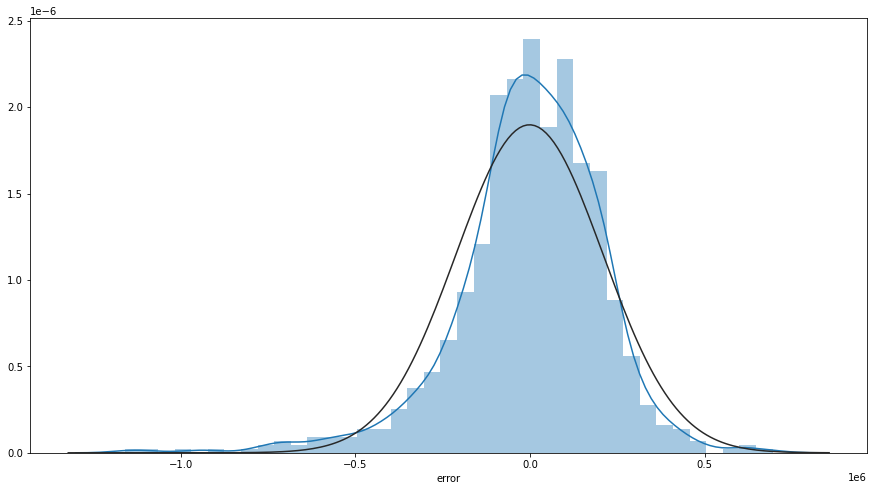

In [24]:
#plot the error
plt.figure(figsize=(15,8))
sns.distplot(resfin_test['error'], fit=norm)

Let's isolate the models error

In [25]:
#standardize the errors
x_array = np.array(resfin_test['error'])
normalized_X = stats.zscore(x_array)

In [26]:
#let's get the normalized error back into our dataset
error_df = pd.DataFrame(data=normalized_X.T, columns=['normalized error'])
resfin2 = resfin_test.join(error_df)
resfin2['abs_norm_error'] = abs(resfin2['normalized error'])
#now let's select only the errors that are 2 standard deviations away from the mean
resfin2['massive underestimation'] = resfin2['normalized error']<-2 

<AxesSubplot:>

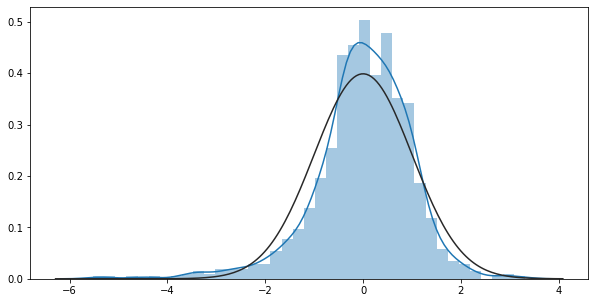

In [27]:
plt.figure(figsize=(10,5))
sns.distplot(error_df, fit=norm)

In [28]:
#how many big mistakes in our test dataset?
resfin2['massive underestimation'].value_counts()

False    871
True      32
Name: massive underestimation, dtype: int64

In [35]:
print(f"approximately {resfin2['massive underestimation'].values.sum()/len(resfin2):.1%} of the test houses are massively underestimated")

approximately 3.5% of the test houses are massively underestimated


No handles with labels found to put in legend.


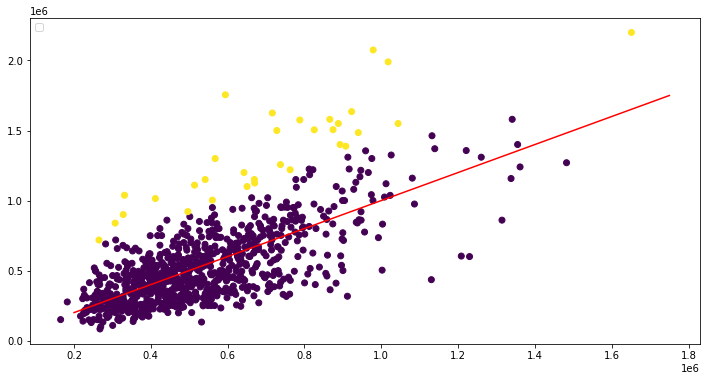

In [36]:
plt.figure(figsize=(12,6))
plt.scatter(resfin2['predprice'], resfin2['actprice'], c = resfin2['massive underestimation'])
plt.plot([0.2*10**6, 1.75*10**6], [0.2*10**6, 1.75*10**6], c = "red")
plt.legend(loc = "upper left")

In [38]:
#Now let's explore - what kind of houses is the model particularly bad at estimating the price of?
pd.crosstab(resfin2['bedrooms'],resfin2['massive underestimation']).apply(lambda r: r/r.sum(), axis=1)

massive underestimation,False,True
bedrooms,,
1.0,1.000000,0.000000
2.0,1.000000,0.000000
3.0,0.974555,0.025445
4.0,0.949686,0.050314
5.0,0.910714,0.089286
6.0,0.875000,0.125000
7.0,1.000000,0.000000
8.0,1.000000,0.000000
9.0,1.000000,0.000000


From this, our model seems to have problems estimating prices of house that has 6 bedrooms

In [39]:
#Now let's explore - what kind of houses is the model particularly bad at estimating the price of?
pd.crosstab(resfin2['bathrooms'],resfin2['massive underestimation']).apply(lambda r: r/r.sum(), axis=1)

massive underestimation,False,True
bathrooms,,
0.75,1.000000,0.000000
1.00,0.974194,0.025806
1.25,1.000000,0.000000
1.50,0.949153,0.050847
1.75,0.983193,0.016807
2.00,0.974684,0.025316
2.25,0.988372,0.011628
2.50,0.983193,0.016807
2.75,0.924528,0.075472


In [41]:
#Now let's explore - what kind of houses is the model particularly bad at estimating the price of?
pd.crosstab(resfin2['view'],resfin2['massive underestimation']).apply(lambda r: r/r.sum(), axis=1)

massive underestimation,False,True
view,,
0,0.966019,0.033981
1,1.000000,0.000000
2,0.909091,0.090909
3,1.000000,0.000000
4,0.923077,0.076923


Let's Visualize the zip code and the house counts

[Text(0, 0, 'WA 98039'),
 Text(1, 0, 'WA 98004'),
 Text(2, 0, 'WA 98040'),
 Text(3, 0, 'WA 98109'),
 Text(4, 0, 'WA 98112'),
 Text(5, 0, 'WA 98119'),
 Text(6, 0, 'WA 98105'),
 Text(7, 0, 'WA 98006'),
 Text(8, 0, 'WA 98033'),
 Text(9, 0, 'WA 98005'),
 Text(10, 0, 'WA 98075'),
 Text(11, 0, 'WA 98053'),
 Text(12, 0, 'WA 98077'),
 Text(13, 0, 'WA 98102'),
 Text(14, 0, 'WA 98199'),
 Text(15, 0, 'WA 98074'),
 Text(16, 0, 'WA 98052'),
 Text(17, 0, 'WA 98122'),
 Text(18, 0, 'WA 98007'),
 Text(19, 0, 'WA 98116'),
 Text(20, 0, 'WA 98024'),
 Text(21, 0, 'WA 98029'),
 Text(22, 0, 'WA 98050'),
 Text(23, 0, 'WA 98177'),
 Text(24, 0, 'WA 98027'),
 Text(25, 0, 'WA 98115'),
 Text(26, 0, 'WA 98065'),
 Text(27, 0, 'WA 98117'),
 Text(28, 0, 'WA 98103'),
 Text(29, 0, 'WA 98072'),
 Text(30, 0, 'WA 98068'),
 Text(31, 0, 'WA 98008'),
 Text(32, 0, 'WA 98107'),
 Text(33, 0, 'WA 98051'),
 Text(34, 0, 'WA 98011'),
 Text(35, 0, 'WA 98059'),
 Text(36, 0, 'WA 98034'),
 Text(37, 0, 'WA 98070'),
 Text(38, 0, 'WA 98136

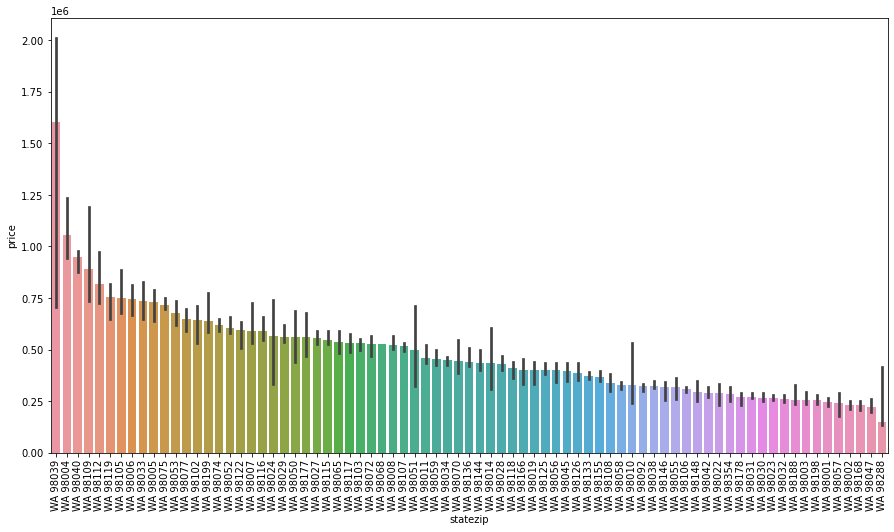

In [42]:
result = df_new.groupby(["statezip"])['price'].aggregate(np.median).reset_index().sort_values('price', ascending=False)
plt.figure(figsize=(15,8))
chart = sns.barplot(
    x='statezip',
    y='price',
    data=df_new,
    order = result['statezip'],
    estimator=np.median
    
    
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

We can see there are a handful of zipcodes that are way more expensive than the rest. Otherwise, statezip doesn't seem to play a huge role in the price of a house.
Let's select the 5 most expensive zips and create a new binary variable called 'posh zip':

In [43]:
df_new['posh_zip'] = df_new['statezip'].isin(['WA 98039','WA 98004','WA 98040','WA 98109','WA 98112']).astype(int)

In [44]:
# Move our features into the X DataFrame
X = df_new.loc[:,['bedrooms', 'floors','view','bathrooms','sqft_above', 'sqft_living', 'posh_zip']]

# Move our labels into the y DataFrame
y = df_new.loc[:,['price']] 

In [45]:
# separate y and X into train and test
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                   )

In [46]:
#train a basic multiple regression model and print out the coefficients
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.900
Model:                            OLS   Adj. R-squared (uncentered):              0.899
Method:                 Least Squares   F-statistic:                              4619.
Date:                Wed, 04 Nov 2020   Prob (F-statistic):                        0.00
Time:                        23:04:47   Log-Likelihood:                         -49102.
No. Observations:                3612   AIC:                                  9.822e+04
Df Residuals:                    3605   BIC:                                  9.826e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [47]:
# Ask the model to predict prices in the train and test set based just on our predictor variables
lr = LinearRegression()
lr.fit(X_train,y_train)
test_pre = lr.predict(X_test)
train_pre = lr.predict(X_train)

In [48]:
#get the results from the regression in dataframe format
res_test = pd.DataFrame(data=test_pre, columns=['predicted values'])
#join with the actual prices
res_test = y_test.reset_index().join(res_test)
#join with the testing dataset
resfin_test = res_test.join(X_test, on='index',lsuffix='_y')
# compute the actual prices, predicted prices and error
resfin_test['predprice']=resfin_test['predicted values']
resfin_test['actprice']=resfin_test['price']
resfin_test['error']=resfin_test['predprice']-resfin_test['actprice']
resdf = pd.concat([resfin,resfin_test])

In [49]:
#standardize the errors
x_array = np.array(resfin_test['error'])
normalized_X = stats.zscore(x_array)

In [50]:
#let's get the normalized error back into our dataset
error_df = pd.DataFrame(data=normalized_X.T, columns=['normalized error'])
resfin2 = resfin_test.join(error_df)
resfin2['abs_norm_error'] = abs(resfin2['normalized error'])
#now let's select only the errors that are 2 standard deviations away from the mean
resfin2['massive underestimation'] = resfin2['normalized error']<-2 

No handles with labels found to put in legend.


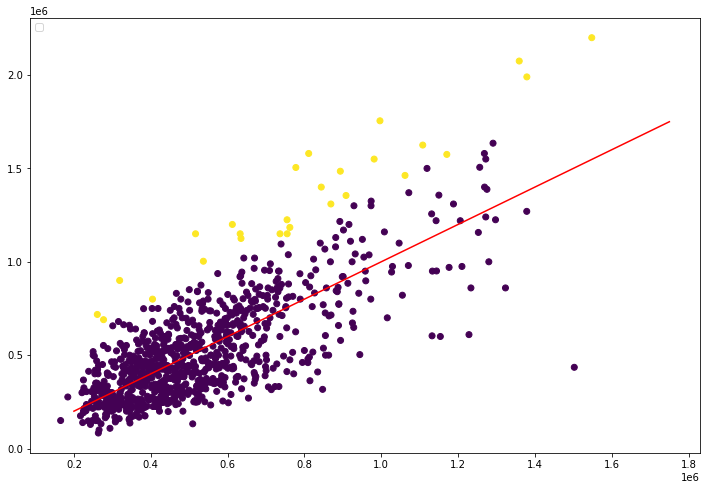

In [51]:
plt.figure(figsize=(12,8))
plt.scatter(resfin2['predprice'], resfin2['actprice'], c = resfin2['massive underestimation'])
plt.plot([0.2*10**6, 1.75*10**6], [0.2*10**6, 1.75*10**6], c = "red")
plt.legend(loc = "upper left")

Our model has one too many variables, but it could me missing something too. The Omnibus test tells us about the probability that the residuals are not normally distributed. The result of this test was zero which means they're not. If they're not normal, it means there is a pattern to the residuals that we're missing, and maybe this pattern could be explained by another variable in our dataset.

For now, let's just check the shape of our residuals:

<AxesSubplot:>

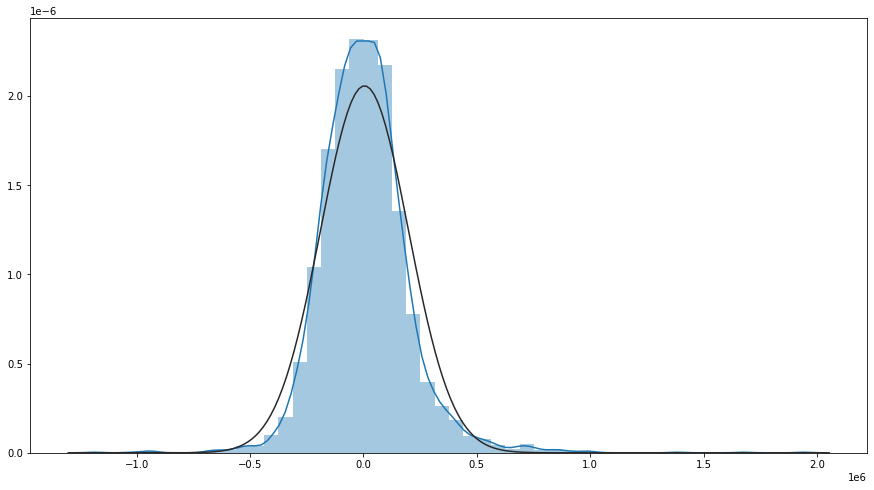

In [52]:
#plot the residuals
plt.figure(figsize=(15,8))
sns.distplot(res.resid, fit=norm)

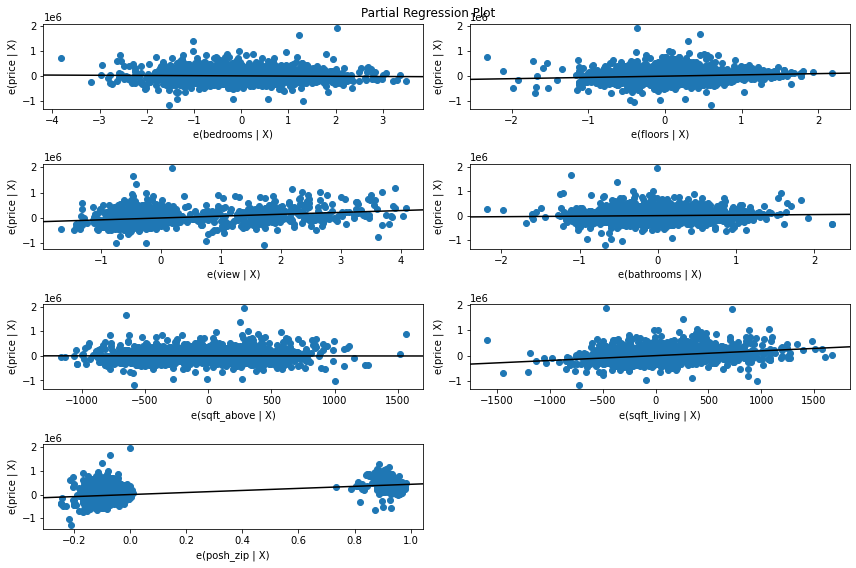

In [55]:
#partial regression plots
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(res, fig=fig)